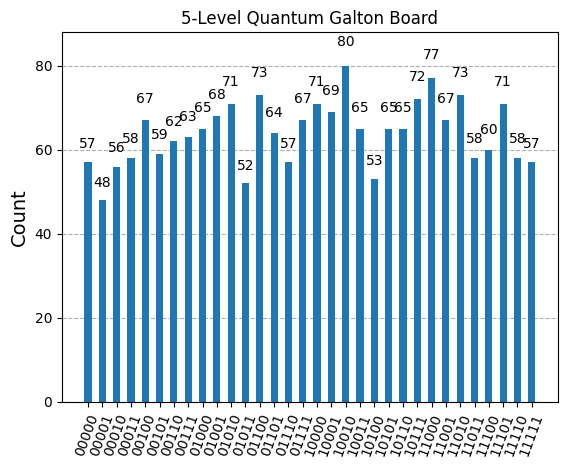

{'01001': 68, '10000': 71, '01010': 71, '00001': 48, '11000': 77, '00110': 62, '00010': 56, '01000': 65, '11011': 58, '10110': 65, '11001': 67, '10001': 69, '01111': 67, '01110': 57, '11010': 73, '01100': 73, '00000': 57, '00101': 59, '10100': 53, '00111': 63, '11111': 57, '10011': 65, '10010': 80, '11101': 71, '01011': 52, '01101': 64, '10101': 65, '00100': 67, '00011': 58, '10111': 72, '11110': 58, '11100': 60}


In [4]:
%matplotlib inline

from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

def generate_galton_board(levels: int):
    qc = QuantumCircuit(levels, levels)
    
    # Apply Hadamard to each qubit to simulate random walk
    for i in range(levels):
        qc.h(i)
    
    # Barrier for clarity (not necessary)
    qc.barrier()
    
    # Measure all qubits
    qc.measure(range(levels), range(levels))
    
    return qc

def run_simulation(levels: int = 5, shots: int = 2048):
    qc = generate_galton_board(levels)
    backend = Aer.get_backend('aer_simulator')
    
    # Transpile and set to run as if on real hardware
    tqc = transpile(qc, backend)
    tqc = backend.run(tqc, shots=shots)
    
    result = tqc.result()
    counts = result.get_counts()
    
    # Plot and show histogram
    plot_histogram(counts, title=f"{levels}-Level Quantum Galton Board")
    plt.show()
    
    return counts

# Run the simulation
counts = run_simulation(levels=5, shots=2048)
print(counts)
